In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import pandas as pd
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
"""
Choose the training data set to be trained on.
"""
dataset = 1

if dataset==1:
    # Training Data set with 10e6 data points for gamma = 0.37, delta = 0.3
    X_train = np.array(pd.read_csv("X_train_mac_lots.csv", header=0, index_col=0))
    y_train = pd.read_csv("y_train_mac_lots.csv", header=0, index_col=0)
    X_test = np.array(pd.read_csv("X_test_mac_lots.csv", header=0, index_col=0))
    y_test = pd.read_csv("y_test_mac_lots.csv", header=0, index_col=0)
elif dataset==2:
    # Training Data set with 10e5 data points for gamma = 0.37, delta = 1
    X_train = np.array(pd.read_csv("X_train_delta1.csv", header=0, index_col=0))
    y_train = pd.read_csv("y_train_delta1.csv", header=0, index_col=0)
    X_test = np.array(pd.read_csv("X_test_delta1.csv", header=0, index_col=0))
    y_test = pd.read_csv("y_test_delta1.csv", header=0, index_col=0)

D:\Anaconda\envs\XAI\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = pd.DataFrame(scaler.transform(X_train), columns=['x0','v0','t'])
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=['x0','v0','t'])

In [56]:
# set up and train the network
input_shape = np.shape(X_train)[1]#, 1)
#opt = RMSprop()
opt = Adam(learning_rate=0.001, beta_1=0.7)

model = Sequential()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))

model.add(layers.Dense(32, activation='relu'))


model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(32, activation='tanh'))
"""
Try LSTM Next: need to do some data preprocessing
model.add(layers.LSTM(128))
model.add(layers.Embedding(input_dim=input_shape, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))
"""
model.add(layers.Dense(2))
loss='mse'
model.compile(optimizer=opt, loss=loss)
history=model.fit(X_train_scale, y_train, steps_per_epoch=None, epochs=5000, validation_split=0.2, batch_size=5096, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/5000
1570/1570 [==============================] - 79s 50ms/step - loss: 0.2801 - val_loss: 0.2104
Epoch 2/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1963 - val_loss: 0.2063
Epoch 3/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1791 - val_loss: 0.1777
Epoch 4/5000
1570/1570 [==============================] - 79s 50ms/step - loss: 0.1700 - val_loss: 0.1707
Epoch 5/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1640 - val_loss: 0.1625
Epoch 6/5000
1570/1570 [==============================] - 77s 49ms/step - loss: 0.1590 - val_loss: 0.1626
Epoch 7/5000
1570/1570 [==============================] - 77s 49ms/step - loss: 0.1550 - val_loss: 0.1618
Epoch 8/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1516 - val_loss: 0.1489
Epoch 9/5000
1570/1570 [==============================] - 77s 49ms/step - loss: 0.1493 - val_loss: 0.1524
Epoch 10/5000
1570/1570 [=====================

In [57]:
# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(X_test_scale), columns=['xt','vt'])



In [58]:
pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y_test[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


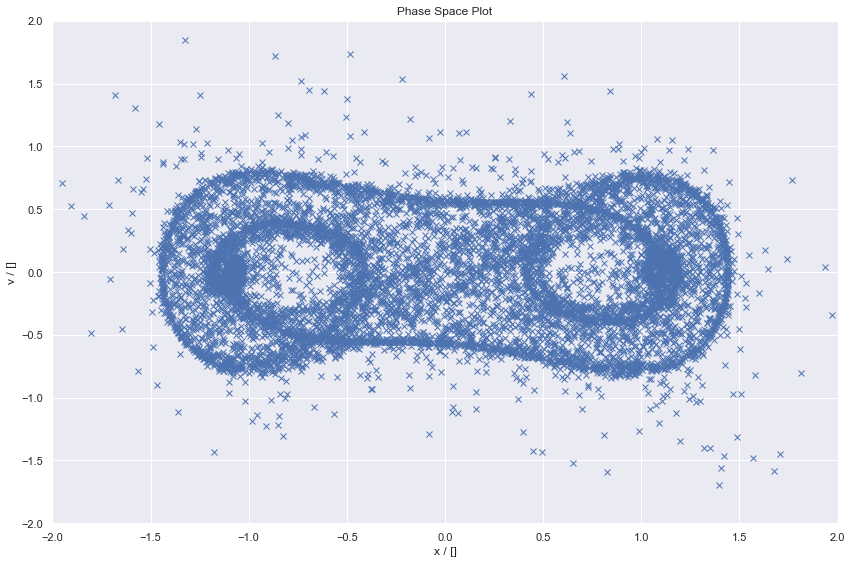

In [119]:
f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = y_test.iloc[:10000,:], x = 'xt', y='vt',ax=axs, marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x / []')
axs.set_ylabel('v / []')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("data_only.svg", dpi='figure')

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


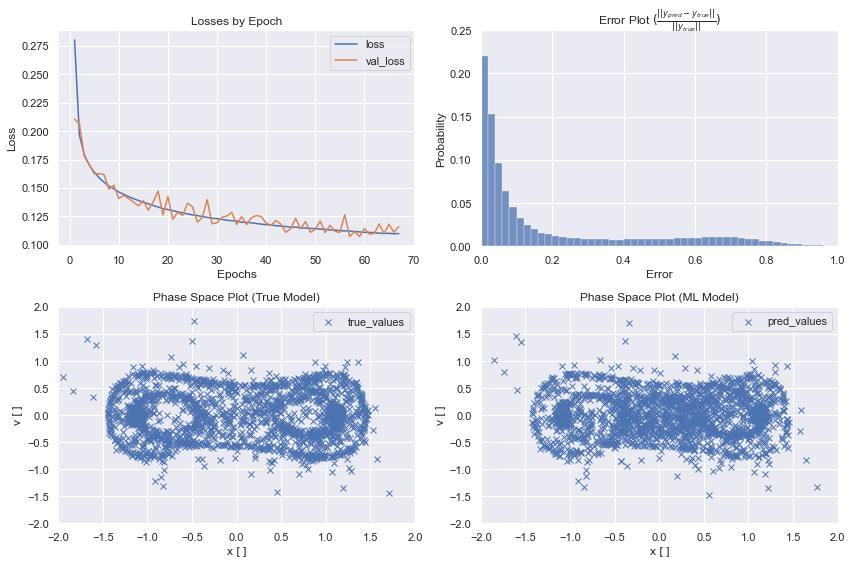

In [371]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.lineplot(data = history.history, x = epochs, y='loss',ax=axs[0,0], label='loss')
sns.lineplot(data = history.history, x = epochs, y='val_loss',ax=axs[0,0], label='val_loss')

axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("Losses by Epoch")
axs[0,0].legend()



sns.scatterplot(data = y_test.iloc[:2000,:], x = 'xt', y='vt',ax=axs[1,0],label='true_values', marker='x', linewidth = 1)

axs[1,0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,0].set_xlabel('x [ ]')
axs[1,0].set_ylabel('v [ ]')
axs[1,0].set_title("Phase Space Plot (True Model)")


sns.scatterplot(data = y_pred.iloc[:2000,:], x='xt', y='vt',ax=axs[1,1],label='pred_values',  marker='x', linewidth = 1)

axs[1,1].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,1].set_xlabel('x [ ]')
axs[1,1].set_ylabel('v [ ]')
axs[1,1].set_title("Phase Space Plot (ML Model)")


sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.02, ax=axs[0,1])
axs[0,1].set(xlim=(0, 1), ylim=(0, 0.25))
axs[0,1].set_xlabel('Error')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")



f.tight_layout()

f.savefig("undamped_duffing_complex_model.svg", dpi='figure')

In [60]:
class TrueModel():
    def __init__(self, scaler):
        self.alpha=-1
        self.beta=1
        self.delta=0.3
        self.gamma=0.37
        self.omega=1.2
        self.scaler = scaler
        
    def inv_transform(self, X):
        return pd.DataFrame(self.scaler.inverse_transform(X), columns=['x0','v0','t'])
       
    def eom(self, u, t):
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X):
        X = self.inv_transform(X)
        X_res = np.ones((np.shape(X)[0], 2))
        for i in range(0,np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i], 500, endpoint=False)
            X_res[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
            
        return X_res


# SHAP Explainability

In [61]:
true_model = TrueModel(scaler)

In [105]:
import shap

background = X_train_scale.iloc[np.random.choice(X_train_scale.shape[0], 1000, replace=False)]

true_explainer = shap.explainers.Permutation(true_model.predict, background)
explainer = shap.explainers.Permutation(model.predict, background)

In [106]:
true_values = true_explainer(X_test_scale.iloc[:1000,:])
model_values = explainer(X_test_scale.iloc[:1000,:])

Permutation explainer: 1001it [5:53:11, 21.19s/it]                           
Permutation explainer: 1001it [07:43,  2.12it/s]                          


In [107]:

print("shap_values =", true_values.values)




print("shap_values =", model_values.values)


shap_values = [[[-0.42271666 -0.03881337]
  [-0.17325787 -0.01632972]
  [-0.61039129 -0.14371742]]

 [[ 0.05014452  0.17767186]
  [ 0.34493438  0.27553886]
  [ 0.13806939 -0.06737018]]

 [[ 0.12730651  0.0486499 ]
  [ 0.06377249  0.17877169]
  [-0.01528181  0.36699122]]

 ...

 [[-0.20075828  0.02721283]
  [ 0.2850026   0.12214972]
  [ 0.5097294   0.08269883]]

 [[ 0.3764478  -0.14559685]
  [ 0.02418146 -0.04413771]
  [ 0.42695901 -0.15827753]]

 [[ 0.16708852  0.22575293]
  [-0.08276763 -0.02793275]
  [ 0.14405499  0.52376076]]]
shap_values = [[[-0.71710219 -0.05685811]
  [-0.29163973 -0.05616334]
  [-0.15085654 -0.0197503 ]]

 [[-0.00384269 -0.00550814]
  [ 0.49409538 -0.02569758]
  [ 0.1350261  -0.16041901]]

 [[ 0.13296677  0.23669695]
  [-0.02194898  0.08164654]
  [-0.00153828  0.24938185]]

 ...

 [[ 0.07926581  0.19840328]
  [ 0.3450263   0.13788353]
  [ 0.24278269 -0.06410108]]

 [[ 0.04241839 -0.06777869]
  [ 0.0392453  -0.03687901]
  [ 0.74135535 -0.22720936]]

 [[ 0.00224537

In [108]:
true_explainer_partition = shap.explainers.Partition(true_model.predict, background)
explainer_partition = shap.explainers.Partition(model.predict, background)

In [129]:
true_values_partition = true_explainer_partition(X_test_scale.iloc[:100,:])
model_values_partition = explainer_partition(X_test_scale.iloc[:100,:])

Partition explainer: 101it [04:28,  2.77s/it]                         
Partition explainer: 101it [00:14,  2.12it/s]                         


In [133]:
true_plotting_data = np.empty((len(true_values_partition.values),6))
plotting_data = np.empty((len(true_values_partition.values),6))

for i in range(len(true_values_partition.values)):
    true_plotting_data[i,:] = true_values_partition.values[i].flatten()
    plotting_data[i,:] = model_values_partition.values[i].flatten()
    
true_plot_data = pd.DataFrame(true_plotting_data, columns = ['x0_xt', 'v0_xt', 't_xt', 'x0_vt', 'v0_vt', 't_vt'])
plot_data = pd.DataFrame(plotting_data, columns = ['x0_xt', 'v0_xt', 't_xt', 'x0_vt', 'v0_vt', 't_vt'])

In [134]:
plot_data.index

RangeIndex(start=0, stop=100, step=1)

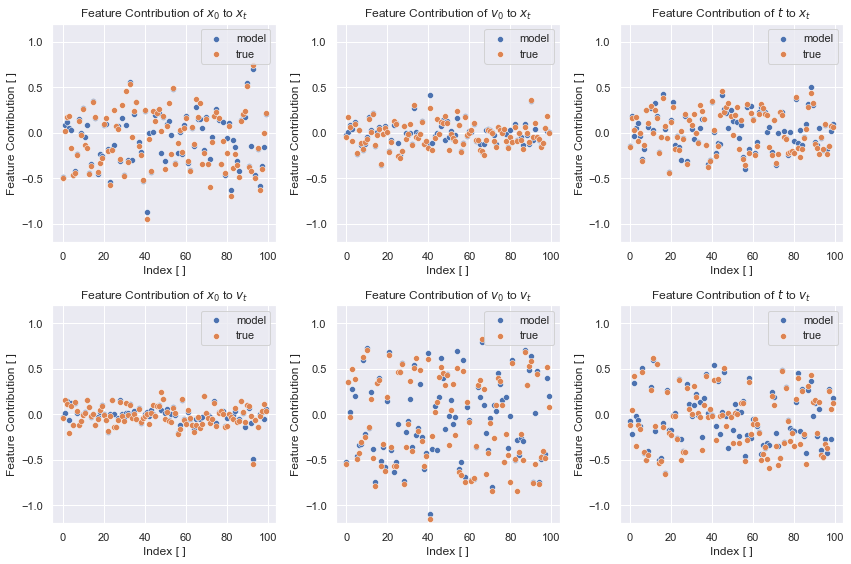

In [364]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4, 4]))



sns.scatterplot(data = plot_data, x = plot_data.index,  y='x0_xt', label = 'model', ax=axs[0,0])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='x0_xt', label='true',ax=axs[0,0])
axs[0,0].set_ylim(-1.2,1.2)
axs[0,0].set_title(r"Feature Contribution of $x_0$ to $x_t$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='v0_xt', label = 'model', ax=axs[0,1])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='v0_xt', label='true',ax=axs[0,1])
axs[0,1].set_ylim(-1.2,1.2)
axs[0,1].set_title(r"Feature Contribution of $v_0$ to $x_t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='t_xt', label = 'model', ax=axs[0,2])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='t_xt', label='true',ax=axs[0,2])
axs[0,2].set_ylim(-1.2,1.2)
axs[0,2].set_title(r"Feature Contribution of $t$ to $x_t$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='x0_vt', label = 'model', ax=axs[1,0])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='x0_vt', label='true',ax=axs[1,0])
axs[1,0].set_ylim(-1.2,1.2)
axs[1,0].set_title(r"Feature Contribution of $x_0$ to $v_t$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='v0_vt', label = 'model', ax=axs[1,1])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='v0_vt', label='true',ax=axs[1,1])
axs[1,1].set_ylim(-1.2,1.2)
axs[1,1].set_title(r"Feature Contribution of $v_0$ to $v_t$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='t_vt', label = 'model', ax=axs[1,2])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='t_vt', label='true',ax=axs[1,2])
axs[1,2].set_ylim(-1.2,1.2)
axs[1,2].set_title(r"Feature Contribution of $t$ to $v_t$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')


f.tight_layout()

f.savefig("undamped_duffing_complex_shap.svg", dpi='figure')

In [395]:
def shap_aggregation_mean(x, model, scaler=scaler):
    
    x.values
    x.data
    x.base_values
    matrix = np.empty((len(x.values), 3, 3))
    aggregate = np.zeros((3,2))
    pred_values = model.predict(x.data)
    
    for i in range(len(x.values)):
        x_t_attribution = np.abs(x.values[i][:,0])
        v_t_attribution = np.abs(x.values[i][:,1])
        aggregate = aggregate + np.hstack((x_t_attribution.reshape((3,1)), v_t_attribution.reshape((3,1))))
        
    aggregate = aggregate/len(x.values)
    aggregate = pd.DataFrame(aggregate, columns = ['xt', 'vt'], index = ['x0','v0','t'])
    
    return matrix , aggregate

In [385]:
def shap_aggregation(x, model, scaler=scaler):
    
    x.values
    x.data
    x.base_values
    matrix = np.empty((len(x.values), 3, 3))
    aggregate = np.zeros((3,2))
    pred_values = model.predict(x.data)
    
    for i in range(len(x.values)):
        x_t_attribution = x.values[i][:,0]/(pred_values[i,0] - x.base_values[i][0])
        v_t_attribution = x.values[i][:,1]/(pred_values[i,1] - x.base_values[i][1])
        aggregate = aggregate + np.hstack((x_t_attribution.reshape((3,1)), v_t_attribution.reshape((3,1))))
        matrix[i,:,:] = np.hstack((scaler.inverse_transform(x.data[i,:]).reshape((3,1)), x_t_attribution.reshape((3,1)), v_t_attribution.reshape((3,1))))
    aggregate = aggregate/len(x.values)
    aggregate = pd.DataFrame(aggregate, columns = ['xt', 'vt'], index = ['x0','v0','t'])
    #aggregate = pd.DataFrame(aggregate, columns = [['x_0','v_0','t'] ,['x_t,x_0','x_t,v_0','x_t,t'], ['v_t,x_0','v_t,v_0','v_t,t']])
    return matrix , aggregate

In [396]:
true_matrix, true_aggregate = shap_aggregation_mean(true_values_partition, true_model)

model_matrix, model_aggregate = shap_aggregation_mean(model_values_partition, model)

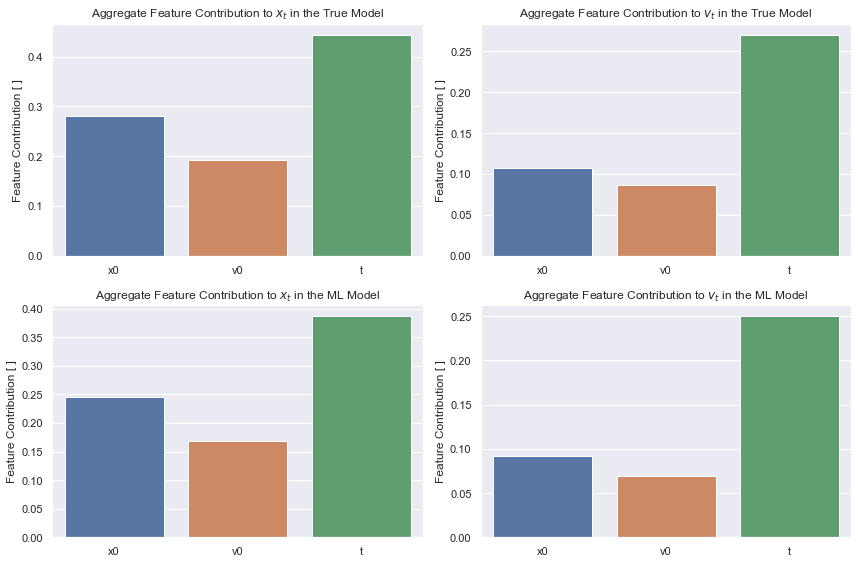

In [408]:
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.barplot(data = true_aggregate, x = true_aggregate.index,  y='xt', label = 'xt', ax=axs[0,0])
axs[0,0].set_title(r"Aggregate Feature Contribution to $x_t$ in the True Model")
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = true_aggregate, x = true_aggregate.index,  y='vt', label = 'vt', ax=axs[0,1])
axs[0,1].set_title(r"Aggregate Feature Contribution to $v_t$ in the True Model")
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = model_aggregate, x = true_aggregate.index,  y='xt', label = 'xt', ax=axs[1,0])
axs[1,0].set_title(r"Aggregate Feature Contribution to $x_t$ in the ML Model")
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = model_aggregate, x = model_aggregate.index,  y='vt', label = 'vt', ax=axs[1,1])
axs[1,1].set_title(r"Aggregate Feature Contribution to $v_t$ in the ML Model")
axs[1,1].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("undamped_duffing_complex_shap_aggregate.svg", dpi='figure')

In [357]:
def test(model, size=10, scaler=scaler):
    heatmap_x = np.linspace(-1.8, 2, size)
    heatmap_v = np.linspace(-2, 2, size)
    #heatmap_t = np.linspace(0, 50, size)
    X_heatmap = np.empty((size**2,3))
    j = size
    for i in range(j):
        X_heatmap[(i*j):(i+1)*j,0] = heatmap_x
        X_heatmap[(i*j):(i+1)*j,1] = np.ones_like(heatmap_x)*heatmap_v[i]
        X_heatmap[(i*j):(i+1)*j,2] = np.ones_like(heatmap_x)*25 #heatmap_t[i]
            
    return X_heatmap
            
tester = test(model, size=5)
hmm = scaler.transform(tester)
hmm_explainer = shap.explainers.Partition(model.predict, background)
hmm_vals = hmm_explainer(X_heatmap)

Partition explainer: 126it [00:17,  3.11it/s]                         


In [359]:
def shap_heatmap(model, size=10, scaler=scaler):
    heatmap_x = np.linspace(-2, 2, size)
    heatmap_v = np.linspace(-2, 2, size)
    heatmap_t = np.linspace(0, 50, size)
    X_heatmap = np.empty((size**3,3))
    j = size
    for i in range(j):
        for k in range(j):
            X_heatmap[(i*j**2+k*j):(i*j**2+(k+1)*j),0] = heatmap_x
            X_heatmap[(i*j**2+k*j):(i*j**2+(k+1)*j),1] = np.ones_like(heatmap_x)*heatmap_v[k]
            X_heatmap[(i*j**2+k*j):(i*j**2+(k+1)*j),2] = np.ones_like(heatmap_x)*25#heatmap_t[i]
            #X_heatmap[i*j:(i+1)*j,0] = heatmap_x
            #X_heatmap[i*j:(i+1)*j,1] = np.ones_like(heatmap_x)*heatmap_v[i]
            #X_heatmap[i*j:(i+1)*j,1] = np.ones_like(heatmap_x)*heatmap_t[k]
    X_heatmap = scaler.transform(X_heatmap)
    heatmap_explainer = shap.explainers.Partition(model.predict, X_heatmap)
    heatmap_vals = heatmap_explainer(X_heatmap)
    aggregated_heatmap = shap_aggregation(heatmap_vals, model)
    
    return aggregated_heatmap, heatmap_explainer, heatmap_vals

In [328]:

"""
def shap_heatmap(model, size=10, scaler=scaler, background=background):
    heatmap_x = np.linspace(-2, 2, size)
    heatmap_v = np.linspace(-2, 2, size)
    #heatmap_t = np.linspace(0, 50, size)
    X_heatmap = np.empty((size**2,3))
    j = size
    for i in range(j):
        X_heatmap[(i*j):(i+1)*j,0] = heatmap_x
        X_heatmap[(i*j):(i+1)*j,1] = np.ones_like(heatmap_x)*heatmap_v[i]
        X_heatmap[(i*j):(i+1)*j,2] = np.ones_like(heatmap_x)*25#heatmap_t[i]
            #X_heatmap[i*j:(i+1)*j,0] = heatmap_x
            #X_heatmap[i*j:(i+1)*j,1] = np.ones_like(heatmap_x)*heatmap_v[i]
            #X_heatmap[i*j:(i+1)*j,1] = np.ones_like(heatmap_x)*heatmap_t[k]
    X_heatmap = scaler.transform(X_heatmap)
    heatmap_explainer = shap.explainers.Partition(model.predict)
    heatmap_vals = heatmap_explainer(X_heatmap)
    aggregated_heatmap = shap_aggregation(heatmap_vals, model)
    
    return aggregated_heatmap, heatmap_explainer, heatmap_vals
    
    """
    

In [360]:
aggregated_heatmap, heatmap_explainer, heatmap_vals = shap_heatmap(true_model, size=20)

Partition explainer: 8001it [6:28:20,  2.91s/it]                            


In [363]:
heatmap_vals

.values =
array([[[ 0.45920737,  0.16708534],
        [ 0.09155683,  0.07068352],
        [ 0.        ,  0.        ]],

       [[ 0.39200929,  0.07436068],
        [ 0.25442243, -0.03770923],
        [ 0.        ,  0.        ]],

       [[-0.59996848, -0.24792663],
        [-0.19677804, -0.44405071],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.74563098,  0.3026636 ],
        [ 0.18688683,  0.09342967],
        [ 0.        ,  0.        ]],

       [[-0.66993456,  0.23994334],
        [-0.37576375, -0.11322335],
        [ 0.        ,  0.        ]],

       [[ 0.21410445, -0.20465685],
        [-0.22311912, -0.31275781],
        [ 0.        ,  0.        ]]])

.base_values =
array([[-0.1526718 , -0.04789268],
       [-0.1526718 , -0.04789268],
       [-0.1526718 , -0.04789268],
       ...,
       [-0.1526718 , -0.04789268],
       [-0.1526718 , -0.04789268],
       [-0.1526718 , -0.04789268]])

.data =
array([[-1.73237134, -3.46420053,  0.00396081],
       [-1.55004704, 

In [331]:
i = 0
Xt_matrix = np.empty((len(aggregated_heatmap), 3))
for i in range(len(aggregated_heatmap)):
    Xt_matrix[i,:] = np.hstack((aggregated_heatmap[i][0,:2], aggregated_heatmap[i][1,0]))
    
Xt_matrix = pd.DataFrame(Xt_matrix, columns=['x0','x0_xt','v0'])

In [332]:
Xt_matrix = Xt_matrix[['x0', 'v0', 'x0_xt']]

In [317]:
pivoted_Xt_matrix = pd.pivot_table(Xt_matrix, index = ['x0','v0'],values = ['x0_xt'])

In [333]:

Xt_matrix

,x0,v0,x0_xt
0,-2.000000,-0.222222,1.000006
1,-1.555556,-0.222222,1.000000
2,-1.111111,-0.222222,1.000000
3,-0.666667,-0.222222,1.000000
4,-0.222222,-0.222222,1.000000
...,...,...,...
95,0.222222,-0.222222,1.000000
96,0.666667,-0.222222,1.000000
97,1.111111,-0.222222,1.000000
98,1.555556,-0.222222,1.000000


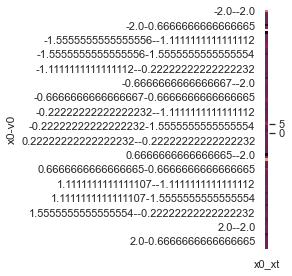

In [320]:
#f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4, 4]))
f, axs = plt.subplots(1, 1, figsize=(4,4), gridspec_kw=dict(width_ratios=[4]))

sns.heatmap(pivoted_Xt_matrix)

f.tight_layout()

#f.savefig("1delta03shap100.svg", dpi='figure')

In [238]:
shap_aggregation(true_values_partition, true_model)

array([[[-1.69100239e+00,  4.15614065e-01,  2.09133226e-01],
        [-9.04810726e-02,  1.29574122e-01,  1.90919849e-01],
        [ 1.73000000e+01,  4.54811813e-01,  5.99946924e-01]],

       [[-1.25782905e+00,  3.29385062e-02,  4.46635034e-01],
        [ 3.15092607e-01,  3.11159489e-01,  4.19082864e-01],
        [ 2.31000000e+01,  6.55902004e-01,  1.34282102e-01]],

       [[ 4.90438941e-01,  9.54760047e-01,  1.02998100e-01],
        [ 1.77384886e-01,  1.92185704e-01,  1.83417442e-01],
        [ 2.23000000e+01, -1.46945752e-01,  7.13584458e-01]],

       [[-1.96035455e+00,  2.16439415e-01,  1.46785371e-01],
        [-3.93023658e-01,  2.01933083e-01,  3.11047172e-01],
        [ 1.74000000e+01,  5.81627502e-01,  5.42167457e-01]],

       [[-1.51597818e+00, -1.20731568e+00,  1.40449900e+00],
        [ 1.84720177e-01, -6.60184132e-01,  1.32433460e+00],
        [ 1.30000000e+01,  2.86749981e+00, -1.72883360e+00]],

       [[-7.84081735e-01,  4.85953165e-01,  4.40170918e-01],
        [-1.79

In [175]:
shap_aggregation(model_values_partition, model)

array([[[ 4.23483609e-01,  2.09082246e-01],
        [ 1.26197158e-01,  2.17097186e-01],
        [ 4.50319228e-01,  5.73820668e-01]],

       [[ 1.33346654e-01, -2.97075052e-02],
        [ 2.97680453e-01, -7.57617073e-02],
        [ 5.68973202e-01,  1.10546919e+00]],

       [[ 1.07961290e+00,  1.46992067e-01],
        [-3.14549005e-01,  2.47803889e-01],
        [ 2.34936153e-01,  6.05204048e-01]],

       [[ 1.46187647e-01, -1.49838696e+00],
        [ 1.46574189e-01,  2.00101616e+00],
        [ 7.07237813e-01,  4.97367438e-01]],

       [[ 7.99175681e-02,  6.80702864e-01],
        [ 3.20680885e-01,  7.24115940e-01],
        [ 5.99402113e-01, -4.04818039e-01]],

       [[ 4.83745015e-01,  4.85358180e-01],
        [ 3.77040024e-02,  2.39896693e-01],
        [ 4.78550982e-01,  2.74745137e-01]],

       [[ 4.03508662e-01,  3.81945192e-02],
        [ 2.72241973e-01,  1.90652558e-01],
        [ 3.24249350e-01,  7.71152937e-01]],

       [[ 3.15212151e-01,  2.40916123e-01],
        [ 2.393125

In [409]:
import lime
import lime.lime_tabular

In [410]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_scale), verbose=True, mode='regression')

In [433]:
X_test_scale.loc[i]

x0    0.556284
v0   -1.375314
t     0.253374
Name: 25, dtype: float64

In [435]:

model.predict(X_test_scale.loc[i:i])

array([[-0.4283203 , -0.35754365]], dtype=float32)

In [437]:


i = 25
lime_exp_model = lime_explainer.explain_instance(X_test_scale.loc[i], model.predict, num_features=3)
lime_exp_true = lime_explainer.explain_instance(X_test_scale.loc[i], true_model.predict, num_features=3)


Intercept 0.024699256514124645
Prediction_local [0.05511071]
Right: -0.42831987
Intercept 0.0016379960864581315
Prediction_local [0.06000786]
Right: 0.8615930791572571


In [419]:
X_test_scale.iloc[i:i+1]

,x0,v0,t
25,0.556284,-1.375314,0.253374


In [420]:
model.predict(X_test_scale.iloc[i:i+1])

array([[-0.4283203 , -0.35754365]], dtype=float32)

In [412]:
true_explainer(X_test_scale.iloc[i:i+1,:]).values

Permutation explainer: 2it [00:21, 21.04s/it]               


array([[[ 0.60201969, -0.47755831],
        [-0.00608509, -0.1303413 ],
        [ 0.14493556, -0.28337832]]])

In [413]:
lime_exp_model.show_in_notebook(show_table=True)

In [414]:
explainer(X_test_scale.iloc[i:i+1,:])

.values =
array([[[-0.27037467, -0.12239212],
        [-0.09715452, -0.00569791],
        [-0.16472109, -0.25636048]]])

.base_values =
array([[0.10393035, 0.02690712]])

.data =
array([[ 0.55628377, -1.37531385,  0.25337406]])

In [415]:
lime_exp_true.show_in_notebook(show_table=True)